# Acoustic Project

In this notebook,
we test the efficiency of several automatic learning models in predicting the localization of a person in a living room based on the sound measured on several microphones.
This project is based on the article “SOUNDCAM: A Dataset for Finding Humans Using Room Acoustics”.

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as sig
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

## Initialization

We start by setting up our datasets and parameters so we can have the same basis in the training of every model we handle.
The dataset can be found in the folders 'Human1' and 'Human2',
which represent two different humans in the same living room environment.

### Room Impulse Response (RIR)

The RIR represents the acoustic properties of a room or environment.
It captures how sound is reflected, absorbed, and diffracted by various surfaces and objects within the room.
The RIR is obtained by recording the response of the room to an impulse or short burst of sound.  
We load the RIR stored in the files 'deconvoled_trim.npy' in the folders 'Human1' and 'Human2',
and we combine them in a single dataset.
The content of this dataset will be used to create the inputs for each model.

In [5]:
rirs_1 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rirs_2 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
rirs = np.append(rirs_1, rirs_2, axis=0)

### Localizations

The output of our models will be the coordinates of a person in a room.
In order to train and test these models,
we load the contents of the files 'centroid.npy' in the folders 'Human1' and 'Human2' into a single dataset.

In [6]:
localizations_1 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
localizations_2 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
localizations = np.append(localizations_1, localizations_2, axis=0)

In [7]:
# Initialise the base parameters for the training
test_size = 0.2
seed = 42

### Result interpretation

In order to understand the results we are given by our models,
we use the mean distance between the expected results and the ones we were given from our testing set.
This distance, defined below, is given in centimeters with a precision of 1 behind the floating point.

In [8]:
def distance(actual, expected):
    diff_x = actual[:, 0] - expected[:, 0]
    diff_y = actual[:, 1] - expected[:, 1]
    return np.sqrt(np.square(diff_x) + np.square(diff_y))

def mean_distance(actual, expected):
    return round(distance(actual, expected).mean(), 0) / 10

## The k-Nearest Neighbors and Linear Regression models

### Root Mean Square (RMS)

RMS is a statistical measure that represents the effective value of a varying quantity, such as an audio signal. 
It is often used to describe the perceived loudness of an audio signal.

In the kNN and Linear Regression models, the RMS is used to reduce the amount of data given as an input.
The code below creates the training and testing sets for these models after calculating the RMS measured by each microphone in the room to use them as inputs instead of the RIRs.

In [9]:
rms = np.sqrt(np.square(rirs).mean(axis=2))
X_train, X_test, y_train, y_test = train_test_split(rms, localizations, test_size=test_size, random_state=seed)

### Implementation of Linear Regression

The implementation of the Linear Regression model is straightforward,
since there are no parameters to take care of.

In [10]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"mean distance: {mean_distance(reg.predict(X_test), y_test)} cm")

mean distance: 149.5 cm


### Implementation of k-Nearest Neighbors

The efficiency of the kNN model depends on the number of neighbors it takes into account during its predictions.
Therefore, we test said efficiency with a number of neighbors ranging from 2 to 9, and select the one with the smallest mean distance to the expected coordinates.

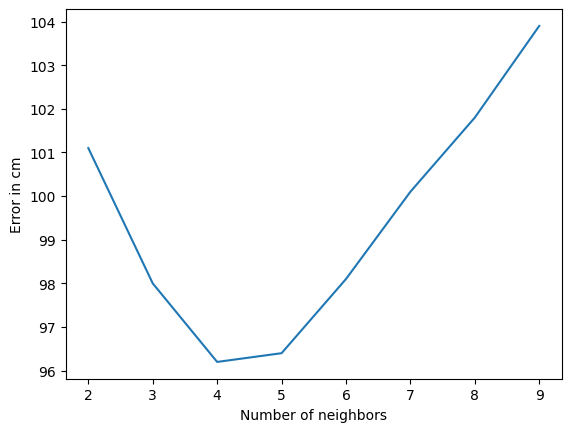

In [11]:
nb_neighbors = []
mean_distance_list = []
for i in range(2, 10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    nb_neighbors.append(i)
    mean_distance_list.append(mean_distance(knn.predict(X_test), y_test))

plt.xlabel("Number of neighbors")
plt.ylabel("Error in cm")
plt.plot(nb_neighbors, mean_distance_list)
plt.show()

The graph shown above is a U-shaped curve with a minimal value when using 4 neighbors.
Indeed, when the number of neighbors increases over 4,
the model tends to over generalize in its predictions, which causes it to have bigger errors overall.

In [12]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
print(f"mean distance: {mean_distance(knn.predict(X_test), y_test)} cm")

mean distance: 96.2 cm


### Truncating the inputs

The sound given as inputs so far were taken from samples of 14 seconds of sound.
Therefore, these samples may contain noise due to reverb for example.

In order to see the impact the sample size may have,
we test the kNN and the Linear Regression models with samples representing only 2 seconds of sound.

In [13]:
# Selecting the first 96000 values for each microphone, because the sound was saved at 48kHz
rms = np.sqrt(np.square(rirs[:, :, :96000]).mean(axis=2))
normalized_rms = (rms - np.mean(rms)) / np.std(rms)

X_train, X_test, y_train, y_test = train_test_split(normalized_rms, localizations, test_size=test_size, random_state=seed)

In [14]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"mean distance: {mean_distance(reg.predict(X_test), y_test)} cm")

mean distance: 149.4 cm


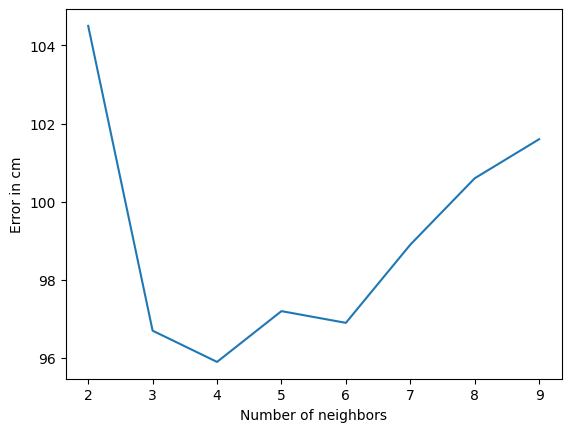

In [15]:
nb_neighbors = []
mean_distance_list = []
for i in range(2, 10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    nb_neighbors.append(i)
    mean_distance_list.append(mean_distance(knn.predict(X_test), y_test))

plt.xlabel("Number of neighbors")
plt.ylabel("Error in cm")
plt.plot(nb_neighbors, mean_distance_list)
plt.show()

In [16]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
print(f"mean distance: {mean_distance(knn.predict(X_test), y_test)} cm")

mean distance: 95.9 cm


## VGGish

VGGish is a Convolutional Neural Network.
Unlike most CNNs, which handle images, VGGish is used to extract features from audio files.
We can then use those features in our own models to get the coordinates we want.

We use an implementation of VGGish made by Google,
which takes the sound data as an input.
This sound data is then turned into a spectrogram in its input preprocessing,
which is an image representing an audio.

In [17]:
import tensorflow_hub as hub

# Loading Google VGGish model from TensorFlow Hub
vggish = hub.load('https://tfhub.dev/google/vggish/1')

2024-04-25 09:28:38.715463: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 09:28:40.585841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 09:28:44.985649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-25 09:29:00.328724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13290 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6


### VGGish with a single channel

We start by creating a model which works with only one channel of sound data instead of the four we have.
In order to create this single channel from all the microphones available to us,
we create the new audio data by calculating the average of each audio sample across all microphones.

We also change the frequency and length of the samples in order to fit with the VGGish model we are currently using.
Instead of a sample of 14 seconds with 48kHz, we give a sample of 1 second with 16kHz.

In [66]:
sound_data = rirs[:, :, ::3].mean(axis = 1)[:, :16000]

outputs = []

for signal in sound_data:
    outputs.append(vggish(signal).numpy())

outputs = np.array(outputs)

In [67]:
trainX, testX, trainY, testY = train_test_split(outputs, localizations, random_state=seed, test_size=test_size)

We create a model which takes the output of VGGish as its input.
This model consists of 3 dense layers, 2 of which are of dimension 256 and with ReLU activations.
The last layer, which gives the coordinates as an output, has a linear activation.

In [20]:
from keras import layers, Sequential, optimizers

model = Sequential([
    layers.Dense(256, input_shape=(128,), use_bias=True, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, use_bias=True, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2, use_bias=True, activation="linear")
])

opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', metrics = ['accuracy'], optimizer=opt)

model.summary()

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,330 (388.01 KB)

 Trainable params: 99,330 (388.01 KB)

 Non-trainable params: 0 (0.00 B)

We start training our model.

In [70]:
trainX_reshaped = trainX.reshape((-1, 128))
testX_reshaped = testX.reshape((-1, 128))

In [22]:
history = model.fit(
    trainX_reshaped, trainY,
    batch_size=32,
    validation_data=(testX_reshaped, testY),
    epochs=1000,
)

Epoch 1/1000


I0000 00:00:1714037353.249311    6826 service.cc:145] XLA service 0x7fafd400bf70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714037353.249393    6826 service.cc:153]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2024-04-25 09:29:13.317281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


19/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7341 - loss: 3454307.5000 

I0000 00:00:1714037357.690163    6826 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.7313 - loss: 3152948.7500 - val_accuracy: 0.7376 - val_loss: 1640430.0000
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7286 - loss: 1583236.8750 - val_accuracy: 0.7376 - val_loss: 1519603.7500
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7243 - loss: 1534398.1250 - val_accuracy: 0.7376 - val_loss: 1501455.7500
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7305 - loss: 1505438.1250 - val_accuracy: 0.7376 - val_loss: 1509184.0000
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7235 - loss: 1530424.0000 - val_accuracy: 0.7376 - val_loss: 1507418.7500
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7279 - loss: 1535724.8750 - val_accuracy: 0.7376 - val_loss: 1468426.7500
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7049 - loss: 1546815.6250 - val_accuracy: 0.7376 - val_loss: 1485428.0000
Epoch 8/1000
28/28 ━━━━━━━━━━━

In [23]:
history_df = pd.DataFrame(history.history)

Here are the graphs representing the loss and accuracy measured during the training of the model,
for both the training set and the validation set.

<Axes: >

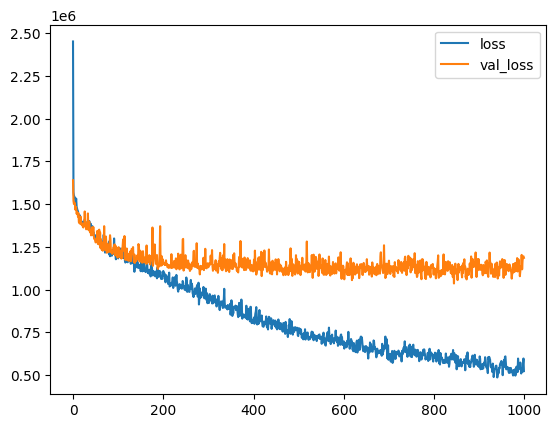

In [24]:
history_df.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

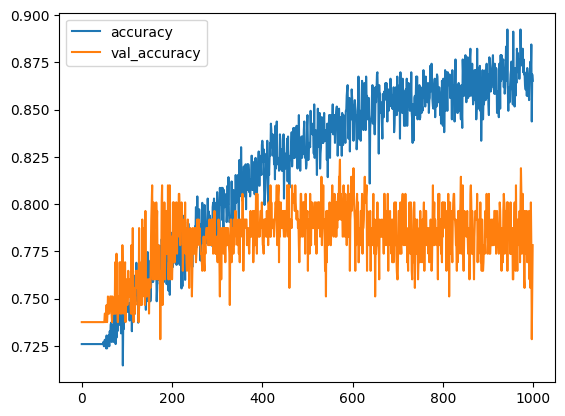

In [25]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [26]:
print(f"mean distance: {mean_distance(model.predict(testX_reshaped), testY)} cm")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
mean distance: 131.1 cm


### VGGish with several channels

Taking the average audio between all available microphones causes some information to be lost.
In order to counter that issue,
we give the pre-trained VGGish the signal of one microphone at a time to have more information available to us.

In [137]:
sound_data = rirs[:, :, ::3][:, :, :16000]

outputs = []
for mic in sound_data:
    signals = []
    for signal in mic:
        signals.append(vggish(signal).numpy())
    outputs.append(signals)

outputs = np.array(outputs)

In [139]:
trainX, testX, trainY, testY = train_test_split(outputs, localizations, random_state=seed, test_size=test_size)

Our model is therefore given 4 lists of features, one for each microphone. We flatten that input so we can handle all the data given to us in the predictions.

In [140]:
model = Sequential([
    layers.Flatten(input_shape=(4, 1, 128)),
    layers.Dense(256, use_bias=True, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, use_bias=True, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2, use_bias=True, activation="linear")
])

opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', metrics = ['accuracy'], optimizer=opt)

model.summary()

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,634 (772.01 KB)

 Trainable params: 197,634 (772.01 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
history = model.fit(
    trainX, trainY,
    batch_size=32,
    validation_data=(testX, testY),
    epochs=1000,
)

Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9520 - loss: 143933.0000 - val_accuracy: 0.8507 - val_loss: 820386.6875


Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9620 - loss: 131161.1406 - val_accuracy: 0.8416 - val_loss: 823925.1875
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9467 - loss: 136126.7500 - val_accuracy: 0.8462 - val_loss: 805811.0625
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9246 - loss: 146444.2188 - val_accuracy: 0.8462 - val_loss: 836287.4375
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9535 - loss: 146576.9844 - val_accuracy: 0.8326 - val_loss: 845863.8125
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9468 - loss: 140123.8906 - val_accuracy: 0.8778 - val_loss: 791454.5625
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9332 - loss: 148238.0312 - val_accuracy: 0.8462 - val_loss: 862168.3125
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9506 - loss: 131755.6719 - val_accuracy: 0.8507 - val_loss: 813798.6875
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━

In [151]:
history_df = pd.DataFrame(history.history)

<Axes: >

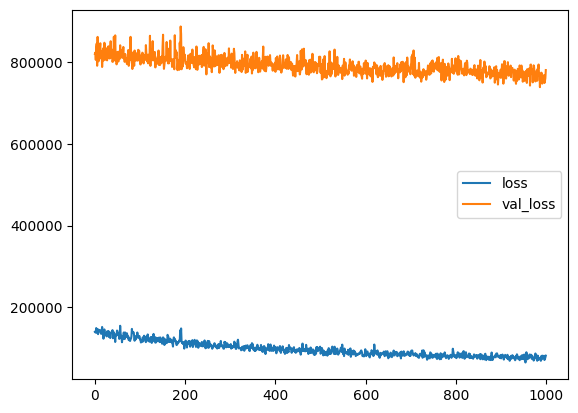

In [152]:
history_df.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

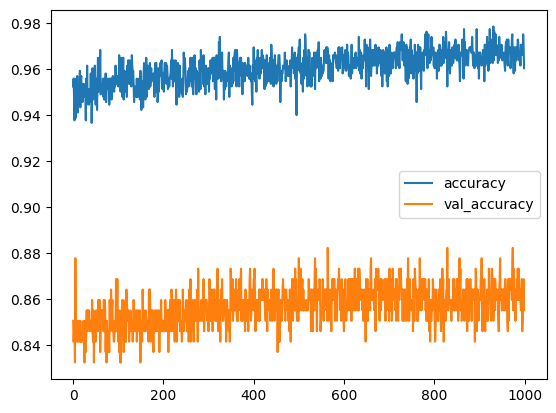

In [153]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [154]:
print(f"mean distance: {mean_distance(model.predict(testX), testY)} cm")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
mean distance: 105.4 cm
